In [ ]:
%reset

# 1. Imports

In [ ]:
import mne
import time

import custom_modules.file_handling as  fh
import custom_modules.classification_ptu as clas

import importlib
importlib.reload(clas)
importlib.reload(fh)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Constants

In [ ]:
data_path = 'D:/Diplomarbeit_data/eeg/'
subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A09', 'A10']
trial_type_markers = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']

mne.set_log_level('WARNING') #'INFO' 'WARNING'

# 3. Classification

## 3.1. Cue-aligned

In [ ]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_cue_aligned', dst_fldr='epoched_cue_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Classifying cue-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=6)

    ### Direction
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=6)

    ### Direction short
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=6)

    ### Direction long
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=6)


print(f'Finished classifying, took me {round(time.time() - start)} seconds...')


## 3.2. Movement-aligned

In [ ]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_movement_aligned_more_time', dst_fldr='epoched_movement_aligned_more_time')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Classifying movement-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=6)

    ### Direction
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=6)

    ### Direction short
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=6)

    ### Direction long
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=1)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=6)


print(f'Finished classifiying, took me {round(time.time() - start)} seconds...')

# 4. Calculate mean + confidence interval for all subjects

In [ ]:
df = pd.read_csv('dataframes/classification/classification_df_minus_2_seconds_for_movement_aligned.csv', index_col=0)

# Calculate CI for all subjects with the same 'N_timepoints', 'Type' and 'Condition' column for each timepoint.
cols = ['Timepoint', 'Mean_accuracy', 'Type', 'N_timepoints', 'Condition', 'Upper', 'Lower']
confidence = .95
df_mean = pd.DataFrame(columns=cols)
for type in df['Type'].unique():
    for n_timepoints in df['N_timepoints'].unique():
        for condition in df['Condition'].unique():
            print(f'{type} {condition} {n_timepoints}')
            timepoints = df[(df['Condition']==condition) & (df['N_timepoints']==n_timepoints) & (df['Type']==type)]['Timepoint'].unique()
            for tp in timepoints:
                # Get average overall subjects for each timepoint:
                accs = np.array(df[(df['Type'] == type) & (df['N_timepoints'] == n_timepoints) & (df['Condition'] == condition) & (df['Timepoint'] == tp)]['Accuracy'])
                mean = accs.mean()

                # Bootstrapping for confidence interval:
                values = [np.random.choice(accs,size=len(accs),replace=True).mean() for i in range(1000)]
                lower, upper = np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])

                df_mean.loc[len(df_mean)] = [tp, mean, type, n_timepoints, condition, upper, lower]

df_mean = df_mean.dropna()

In [ ]:
for type in df_mean['Type'].unique():
    for condition in df_mean['Condition'].unique():
        leg = []
        plt.figure(figsize=(10,6))

        for windowed in df_mean['N_timepoints'].unique():
            # Extract tps, means and confidences to plot:
            timepoints = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Timepoint'])

            means = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Mean_accuracy'])

            uppers = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Upper'])

            lowers = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Lower'])

            txt = f'{windowed}-point windowed'

            leg.append(txt + ' mean')
            leg.append(txt + ' 95% confidence interval')

            plt.plot(timepoints, means)
            plt.fill_between(timepoints, lowers, uppers, alpha=0.1)

        if 'distance' in condition:
            plt.plot([timepoints[0]-(windowed+1)/10, timepoints[-1]], [.5, .5], color='black')
        else:
            plt.plot([timepoints[0]-(windowed+1)/10, timepoints[-1]], [.25, .25], color='black')

        leg.append('Chance level')
        plt.title(f'Classification accuracy for {type} {condition}')
        plt.legend(leg, loc='best')
        plt.ylim([0,1])
        plt.savefig(f'{data_path}classification_figs/{type}_{condition}_classification.png', dpi=400)
        plt.show()

# 5. Estimate GLM

## 5.1. Cue-aligned

In [15]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_cue_aligned', dst_fldr='glm_results_cue_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Fitting GLM cue-aligned for subject {subject}')

    clas.glm(src=src_path, dst=dst_path, sbj=subject)

print(f'Finished with GLM, took me {round(time.time() - start)} seconds...')



Fitting GLM cue-aligned for subject A01
Fitting GLM cue-aligned for subject A02
Fitting GLM cue-aligned for subject A03
Fitting GLM cue-aligned for subject A04
Fitting GLM cue-aligned for subject A05
Fitting GLM cue-aligned for subject A06
Fitting GLM cue-aligned for subject A07
Fitting GLM cue-aligned for subject A08
Fitting GLM cue-aligned for subject A09
Fitting GLM cue-aligned for subject A10
Finished with GLM, took me 22 seconds...


In [16]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='glm_results_cue_aligned', dst_fldr='glm_results_cue_aligned')

clas.coefficient_testing(src=src_path, dst=dst_path, sbj_list=subjects)

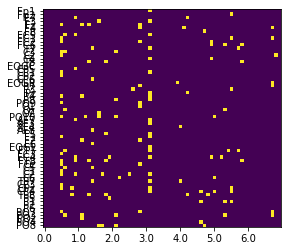

In [38]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='glm_results_cue_aligned', dst_fldr='glm_results_cue_aligned')

clas.plot_heatmap_of_regr_coeff(src=src_path, dst=dst_path, p_crit=0.05)

## 5.2. Movement-aligned

In [28]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_movement_aligned', dst_fldr='glm_results_movement_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Fitting GLM movement-aligned for subject {subject}')

    clas.glm(src=src_path, dst=dst_path, sbj=subject)


print(f'Finished with GLM, took me {round(time.time() - start)} seconds...')

Fitting GLM movement-aligned for subject A01
Fitting GLM movement-aligned for subject A02
Fitting GLM movement-aligned for subject A03
Fitting GLM movement-aligned for subject A04
Fitting GLM movement-aligned for subject A05
Fitting GLM movement-aligned for subject A06
Fitting GLM movement-aligned for subject A07
Fitting GLM movement-aligned for subject A08
Fitting GLM movement-aligned for subject A09
Fitting GLM movement-aligned for subject A10
Finished with GLM, took me 21 seconds...


In [29]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='glm_results_movement_aligned', dst_fldr='glm_results_movement_aligned')

clas.coefficient_testing(src=src_path, dst=dst_path, sbj_list=subjects)

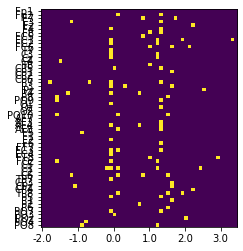

In [39]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='glm_results_movement_aligned', dst_fldr='glm_results_movement_aligned')

clas.plot_heatmap_of_regr_coeff(src=src_path, dst=dst_path, p_crit=0.05)

# 6. Confusion matrices

# 6.1. Cue algined

In [ ]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_cue_aligned', dst_fldr='classification_figs')

ts_list = list(np.arange(0.1,7.0,0.1))

for ts in ts_list:
    clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts, n_timepoints=1, condition='distance')

# clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=2.2, n_timepoints=6)


# Mapping: 0-up, 1-down, 2-right, 3-left

# 6.2. Movement aligned

# Helper cell to add 'Condition' column to the classification dataframe
Outdated, already added to custom_modules/classification_ptu.py.

In [ ]:
# But first add condition to the dataframe as a helper cell:
cond_1 = ['distance'] * 70
cond_2 = ['distance'] * 65
cond_3 = ['direction'] * 70
cond_4 = ['direction'] * 65
cond_5 = ['direction_short'] * 70
cond_6 = ['direction_short'] * 65
cond_7 = ['direction_long'] * 70
cond_8 = ['direction_long'] * 65

cue_cond = cond_1 + cond_2 + cond_3 + cond_4 + cond_5 + cond_6 + cond_7 + cond_8

cue_cond = cue_cond * 10

cond_9 = ['distance'] * 55
cond_10 = ['distance'] * 50
cond_11 = ['direction'] * 55
cond_12 = ['direction'] * 50
cond_13 = ['direction_short'] * 55
cond_14 = ['direction_short'] * 50
cond_15 = ['direction_long'] * 55
cond_16 = ['direction_long'] * 50

mov_cond = cond_9 + cond_10 + cond_11 + cond_12 + cond_13 + cond_14 + cond_15 + cond_16
mov_cond = mov_cond * 10
conds = cue_cond + mov_cond

df = pd.read_csv('dataframes/classification/classification_df.csv', index_col=0)
df['Condition'] = conds

In [ ]:
df.to_csv('dataframes/classification/classification_df.csv')